## Peptides-Modifications Matching Problem

### Load data to a pandas dataframe

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from networkx.algorithms import bipartite
import networkx as nx

%matplotlib inline

df = pd.read_csv('data', delimiter = "\t")
df

,spectrum_key,peptide_key,peptide_sequence,n_mods,p_score,d_score,modification_mass,modification_site
0,8346079174197888067,1526271875777244526,ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTV...,14.01565006414:1,0.000017,0.0,14.015650,4
1,8346079174197888067,1526271875777244526,ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTV...,14.01565006414:1,0.456230,0.0,14.015650,14
2,8346079174197888067,1526271875777244526,ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTV...,14.01565006414:1,0.456230,0.0,14.015650,18
3,8346079174197888067,1526271875777244526,ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTV...,14.01565006414:1,0.456230,0.0,14.015650,23
4,8346079174197888067,1526271875777244526,ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTV...,14.01565006414:1,0.456230,0.0,14.015650,27
...,...,...,...,...,...,...,...,...
15195,-2532221026069166821,5125541582210564031,MALTKQTARKSTGGKAPRKQLATKATRKSAPSTGGVKKPHRYRPGT...,42.04695019242:3_42.0105646837:4,74.811981,0.0,42.010565,15
15196,-2532221026069166821,5125541582210564031,MALTKQTARKSTGGKAPRKQLATKATRKSAPSTGGVKKPHRYRPGT...,42.04695019242:3_42.0105646837:4,74.811981,0.0,42.010565,37
15197,-2532221026069166821,5125541582210564031,MALTKQTARKSTGGKAPRKQLATKATRKSAPSTGGVKKPHRYRPGT...,42.04695019242:3_42.0105646837:4,74.811981,0.0,42.010565,19
15198,-2532221026069166821,5125541582210564031,MALTKQTARKSTGGKAPRKQLATKATRKSAPSTGGVKKPHRYRPGT...,42.04695019242:3_42.0105646837:4,99.813877,0.0,42.046950,5


#### Find matching of peptide-modifications graph

In [7]:
def find_subgraph_matching(df, sample):
    sample = df.loc[(df['spectrum_key'] == sample['spectrum_key']) & (df['peptide_key'] == sample['peptide_key'])]
    n = len(sample['modification_site'].unique().tolist())
    modifications_num_dict = {float(x.split(':')[0]) : int(x.split(':')[1]) for x in sample['n_mods'].iloc[1].split('_')}
    k = sum(modifications_num_dict.values())
    A = sample['modification_site'].unique().tolist()
    D = [key for key in modifications_num_dict for i in range(modifications_num_dict[key])]
    V = A + D
    keys = [key for key in modifications_num_dict]
    V_names = ['site '+str(i) for i in A] + ['mod '+str(i)+' occ '+str(j) for i in range(len(keys)) for j in     range(modifications_num_dict[keys[i]])]
    E = []
    for index, row in sample.iterrows():
        net_edges = [(V_names[A.index(row['modification_site'])], V_names[len(A)+i], row['p_score']) for i in         np.where(np.array(D)==row['modification_mass'])[0].tolist()]
        E = E + net_edges

    G = nx.Graph()
    # Add nodes with the node attribute "bipartite"
    G.add_nodes_from(V_names[:len(A)], bipartite=0)
    G.add_nodes_from(V_names[len(A):], bipartite=1)
    G.add_weighted_edges_from(E)
    
    matching = nx.algorithms.max_weight_matching(G)
    matching_weights_sum = 0.0
    matching_edges = []
    for m in matching:
        match_info = [sample['spectrum_key'].iloc[0], sample['peptide_key'].iloc[0]]
        for e in E:
            if m[0] in str(e) and m[1] in str(e):
                matching_weights_sum += e[2]
                if 'site' in m[0]:
                    match_info.append(int(m[0].split(' ')[1]))
                    match_info.append(D[V_names.index(m[1])-len(A)])
                else:
                    match_info.append(int(m[1].split(' ')[1]))
                    match_info.append(D[V_names.index(m[0])-len(A)])
        matching_edges.append(match_info)
    return matching_edges, len(V), len(E)

#### Get all different pairs of spectrum_key peptide_key values

In [8]:
samples = df[['spectrum_key','peptide_key']].drop_duplicates()
matchings_info = []
graph_statistics = []
for index, sample in samples.iterrows():
    matching, num_V, num_E = find_subgraph_matching(df, sample)
    for e in matching:
        matchings_info.append(e)
    graph_statistics.append([num_V, num_E])
print(matchings_info[0])
print('Number of nodes:', graph_statistics[0][0])
print('Number of edges:', graph_statistics[0][1])

[8346079174197888067, 1526271875777244526, 9, 14.01565006414]
Number of nodes: 9
Number of edges: 8


### Violin plots of graph sizes

In [16]:
plotted_num_nodes = np.array(graph_statistics)[:,0].tolist()
plotted_num_edges = np.array(graph_statistics)[:,1].tolist()

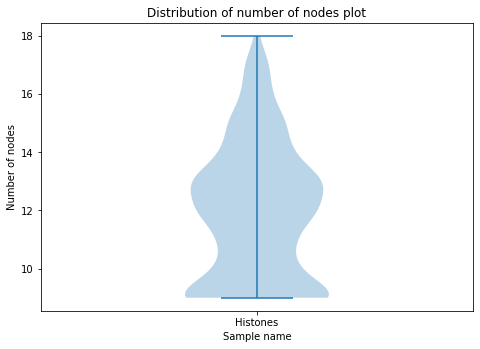

In [21]:
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bp = ax.violinplot(plotted_num_nodes)
ax.set_title('Distribution of number of nodes plot')
ax.set_ylabel('Number of nodes')

labels = ['Histones']
set_axis_style(ax, labels)

plt.show()

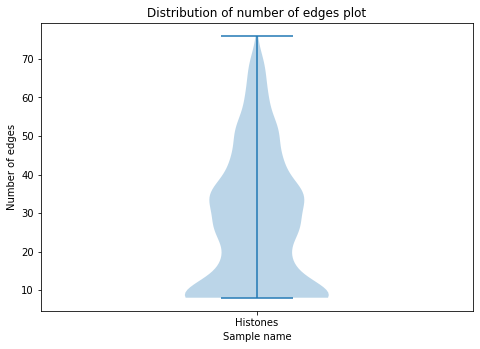

In [22]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bp = ax.violinplot(plotted_num_edges)
ax.set_title('Distribution of number of edges plot')
ax.set_ylabel('Number of edges')

labels = ['Histones']
set_axis_style(ax, labels)

plt.show()